# Quantum Circuit Discovery with Mellea + Ollama

This notebook demonstrates how to use **Mellea agents** with a **local Ollama LLM**
to discover and evaluate novel quantum circuits.


In [2]:
# Install dependencies (run once)
!pip install mellea qiskit qiskit-aer numpy matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.7 MB/s eta 0:00:05
   --- ------------------------------------ 0.8/8.1 MB 1.5 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 1.4 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.1 MB 1.2 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.1 MB 1.2 MB/s eta 0:00:06
   --------- ------------------------------ 1.8/8.1 MB 1.2 MB/s eta 0:00:06
   --------- ------------------------------ 1.8/8.1 MB 1.2 MB/s eta 0:00:06
   ---------- ----------------------------- 2.1/8.1 MB 1.1 MB/s eta 0:00:06
   ---------- ----------------------------- 2.1/8.1 MB 1.1 MB/s eta 0:00:06
   ----------- ---------------------------- 2.4/8.1 MB 1.0 MB/s eta 0:00:06
   ----------- -----------------------


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Ollama + Mellea Configuration

Ensure Ollama is running locally with the Granite model:
```bash
ollama serve
ollama pull granite3.3:2b
```

**Note:** You can also use other models like `granite4:tiny-h` or `llama3.2:3b`

In [1]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import mellea


In [2]:
# Start a Mellea session with Ollama backend
session = mellea.start_session(
    backend_name="ollama",
    model_id="granite3.3:2b",
)

=== 12:41:50-INFO ======
Starting Mellea session: backend=ollama, model=granite3.3:2b, context=SimpleContext


## Quantum Circuit JSON Schema


In [3]:
CIRCUIT_SCHEMA = """
You must output a quantum circuit as valid JSON:
{
  \"num_qubits\": <int>,
  \"gates\": [
    {\"name\": \"h\", \"targets\": [0]},
    {\"name\": \"cx\", \"control\": 0, \"target\": 1},
    {\"name\": \"rz\", \"targets\": [1], \"theta\": \"pi/4\"}
  ]
}

Allowed gates:
- h, x, y, z
- rx, ry, rz (theta required)
- cx, cz
- measure
"""


## Circuit Generator Agent


In [4]:
# System prompt for circuit generation
GENERATOR_SYSTEM_PROMPT = f"""
You are a quantum algorithms researcher.

Your goal:
- Propose novel, compact quantum circuits
- Focus on entanglement, interference, or variational structure
- Avoid textbook circuits (Bell, GHZ, QFT)

Constraints:
- 2–5 qubits
- <= 12 gates
- Output JSON ONLY (no markdown, no explanation)

{CIRCUIT_SCHEMA}
"""

def generate_circuit(goal: str) -> str:
    """Generate a quantum circuit using Mellea."""
    full_prompt = f"""{GENERATOR_SYSTEM_PROMPT}

Task: Design a quantum circuit for: {goal}

Respond with valid JSON only, no explanation."""
    
    response = session.instruct(full_prompt)
    return str(response)

## Circuit Critic Agent


In [5]:
# System prompt for circuit critique
CRITIC_SYSTEM_PROMPT = """
You are a skeptical quantum computing reviewer.

Given a quantum circuit:
- Assess novelty
- Assess potential algorithmic usefulness
- Identify redundancies
- Suggest improvements

Respond in JSON only (no markdown):
{
  "novelty_score": 0-10,
  "usefulness_score": 0-10,
  "comments": "...",
  "suggested_changes": "..."
}
"""

def critique_circuit(spec: dict, counts: dict) -> str:
    """Critique a quantum circuit using Mellea."""
    full_prompt = f"""{CRITIC_SYSTEM_PROMPT}

Circuit:
{json.dumps(spec, indent=2)}

Measurement results:
{counts}

Analyze this circuit and respond with JSON only."""
    
    response = session.instruct(full_prompt)
    return str(response)

## Qiskit Evaluation Utilities


In [6]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import re
import math

def extract_json(text: str) -> str:
    """Extract JSON from LLM response (handles markdown code blocks)."""
    # Try to find JSON in code blocks first
    code_block_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', text, re.DOTALL)
    if code_block_match:
        return code_block_match.group(1)
    
    # Try to find raw JSON object
    json_match = re.search(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', text, re.DOTALL)
    if json_match:
        return json_match.group(0)
    
    return text

def parse_theta(theta_str):
    """Parse theta value that might be a string like 'pi/4' or a number."""
    if isinstance(theta_str, (int, float)):
        return float(theta_str)
    # Handle string expressions like "pi/4", "pi/2", etc.
    theta_str = str(theta_str).strip()
    theta_str = theta_str.replace("pi", str(math.pi))
    theta_str = theta_str.replace("π", str(math.pi))
    try:
        return float(eval(theta_str))
    except:
        return math.pi / 4  # Default fallback

def build_qiskit_circuit(spec: dict) -> QuantumCircuit:
    """Build a Qiskit circuit from JSON specification."""
    n_qubits = spec["num_qubits"]
    qc = QuantumCircuit(n_qubits)
    
    def clamp_qubit(q):
        """Ensure qubit index is within valid range."""
        return max(0, min(int(q), n_qubits - 1))
    
    for gate in spec.get("gates", []):
        name = gate["name"].lower()
        
        if name == "h":
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                qc.h(clamp_qubit(t))
        elif name == "x":
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                qc.x(clamp_qubit(t))
        elif name == "y":
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                qc.y(clamp_qubit(t))
        elif name == "z":
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                qc.z(clamp_qubit(t))
        elif name in ["rx", "ry", "rz"]:
            theta = parse_theta(gate.get("theta", "pi/4"))
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                getattr(qc, name)(theta, clamp_qubit(t))
        elif name == "cx" or name == "cnot":
            ctrl = gate.get("control", gate.get("controls", [0]))
            tgt = gate.get("target", gate.get("targets", 1))
            if isinstance(ctrl, list):
                ctrl = ctrl[0]
            if isinstance(tgt, list):
                tgt = tgt[0]
            ctrl = clamp_qubit(ctrl)
            tgt = clamp_qubit(tgt)
            # Ensure control != target
            if ctrl == tgt:
                tgt = (ctrl + 1) % n_qubits
            qc.cx(ctrl, tgt)
        elif name == "cz":
            ctrl = gate.get("control", gate.get("controls", [0]))
            tgt = gate.get("target", gate.get("targets", 1))
            if isinstance(ctrl, list):
                ctrl = ctrl[0]
            if isinstance(tgt, list):
                tgt = tgt[0]
            ctrl = clamp_qubit(ctrl)
            tgt = clamp_qubit(tgt)
            # Ensure control != target
            if ctrl == tgt:
                tgt = (ctrl + 1) % n_qubits
            qc.cz(ctrl, tgt)
    
    return qc

def simulate_circuit(qc: QuantumCircuit, shots: int = 1024) -> dict:
    """Simulate the circuit and return measurement counts."""
    sim = AerSimulator()
    qc_with_measure = qc.copy()
    qc_with_measure.measure_all()
    job = sim.run(qc_with_measure, shots=shots)
    return job.result().get_counts()

## Discovery Loop


In [7]:
def discovery_step(goal: str):
    """Run one discovery step: generate, simulate, critique."""
    print(f"🎯 Goal: {goal}\n")
    
    # Generate circuit
    print("🔧 Generating circuit...")
    circuit_json = generate_circuit(goal)
    print(f"Raw response:\n{circuit_json}\n")
    
    # Parse JSON
    try:
        json_str = extract_json(circuit_json)
        spec = json.loads(json_str)
        print(f"✅ Parsed circuit spec successfully")
    except json.JSONDecodeError as e:
        print(f"❌ JSON parse error: {e}")
        print("Attempting to create a default circuit...")
        spec = {
            "num_qubits": 3,
            "gates": [
                {"name": "h", "targets": [0]},
                {"name": "cx", "control": 0, "target": 1},
                {"name": "cx", "control": 1, "target": 2}
            ]
        }
    
    # Build and simulate
    print("\n⚛️ Building Qiskit circuit...")
    qc = build_qiskit_circuit(spec)
    print(qc.draw(output='text'))
    
    print("\n🔬 Simulating...")
    counts = simulate_circuit(qc)
    
    # Critique
    print("\n📝 Getting critique...")
    critique = critique_circuit(spec, counts)
    
    return spec, qc, counts, critique

## Run an Example


In [8]:
# Reset session for clean demo run (optional)
session.reset()

In [9]:
# Run a discovery step
goal = "Generate high-entropy measurement distributions using minimal entanglement"

spec, qc, counts, critique = discovery_step(goal)

print("\n" + "="*60)
print("📊 RESULTS")
print("="*60)
print("\n🔹 Circuit Specification:")
print(json.dumps(spec, indent=2))
print("\n🔹 Measurement Counts:")
print(counts)
print("\n🔹 Critique:")
print(critique)

🎯 Goal: Generate high-entropy measurement distributions using minimal entanglement

🔧 Generating circuit...


  0%|                                                                                               | 0/2 [00:00<?, ?it/s]

=== 12:50:54-INFO ======
SUCCESS


  0%|                                                                                               | 0/2 [00:10<?, ?it/s]


Raw response:
{
  "num_qubits": 2,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "cx", "control": 1, "target": 0},
    {"name": "h", "targets": [1]}
  ]
}

✅ Parsed circuit spec successfully

⚛️ Building Qiskit circuit...
     ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├─────
     └───┘└─┬─┘┌───┐
q_1: ───────■──┤ H ├
               └───┘

🔬 Simulating...

📝 Getting critique...


  0%|                                                                                               | 0/2 [00:00<?, ?it/s]

=== 12:50:55-INFO ======
SUCCESS


  0%|                                                                                               | 0/2 [00:01<?, ?it/s]


📊 RESULTS

🔹 Circuit Specification:
{
  "num_qubits": 2,
  "gates": [
    {
      "name": "h",
      "targets": [
        0
      ]
    },
    {
      "name": "cx",
      "control": 1,
      "target": 0
    },
    {
      "name": "h",
      "targets": [
        1
      ]
    }
  ]
}

🔹 Measurement Counts:
{'01': 240, '00': 257, '10': 277, '11': 250}

🔹 Critique:
{
  "novelty_score": 6,
  "usefulness_score": 8,
  "comments": "This quantum circuit is a basic implementation of the Controlled-Hadamard (CH) gate, which is not particularly novel but still holds significant utility in quantum algorithms. The CH gate is a fundamental building block for many quantum algorithms, especially those involving quantum error correction and quantum phase estimation.",
  "suggested_changes": "The circuit could be improved by adding measurements to verify the state entanglement generated by the CH gate. Additionally, incorporating more qubits or extending the circuit to include multiple CH gates would e

## Visualize Results

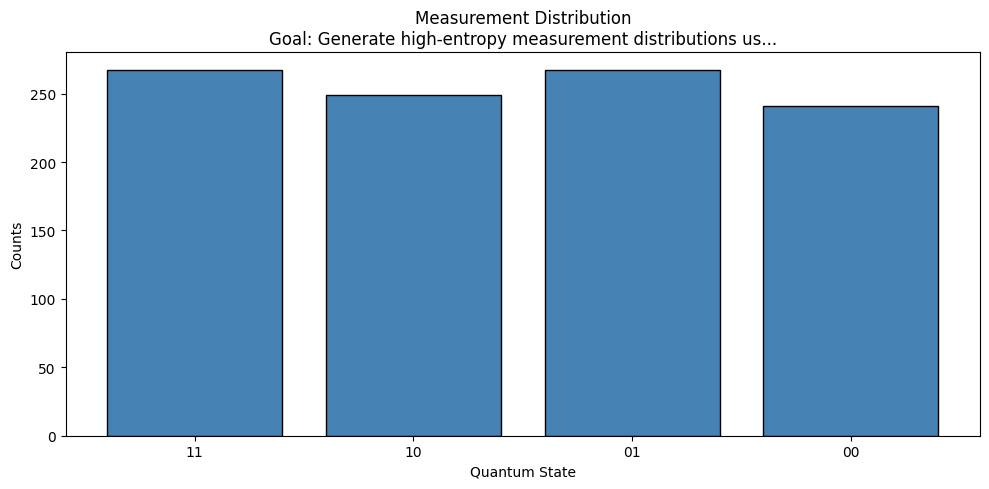

In [25]:
# Visualize the measurement distribution
def plot_counts(counts: dict, title: str = "Measurement Distribution"):
    """Plot measurement counts as a bar chart."""
    states = list(counts.keys())
    values = list(counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(states, values, color='steelblue', edgecolor='black')
    plt.xlabel('Quantum State')
    plt.ylabel('Counts')
    plt.title(title)
    plt.xticks(rotation=45 if len(states) > 8 else 0)
    plt.tight_layout()
    plt.show()

plot_counts(counts, f"Measurement Distribution\nGoal: {goal[:50]}...")

## Try Different Goals

Let's explore different quantum computing objectives!

🎯 Goal: Create a circuit that produces a uniform superposition over 3 qubits with phase differences

🔧 Generating circuit...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:47:33-INFO ======
SUCCESS


  0%|          | 0/2 [00:16<?, ?it/s]


Raw response:
{
  "num_qubits": 3,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "h", "targets": [1]},
    {"name": "cx", "control": 2, "target": 0},
    {"name": "cx", "control": 1, "target": 0},
    {"name": "rz", "targets": [0], "theta": "pi/4"},
    {"name": "cz", "controls": [0], "target": 1}
  ]
}

✅ Parsed circuit spec successfully

⚛️ Building Qiskit circuit...
     ┌───┐┌───┐┌───┐┌─────────┐   
q_0: ┤ H ├┤ X ├┤ X ├┤ Rz(π/4) ├─■─
     ├───┤└─┬─┘└─┬─┘└─────────┘ │ 
q_1: ┤ H ├──┼────■──────────────■─
     └───┘  │                     
q_2: ───────■─────────────────────
                                  

🔬 Simulating...

📝 Getting critique...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:48:00-INFO ======
SUCCESS


  0%|          | 0/2 [00:26<?, ?it/s]


📊 RESULTS

🔹 Measurement Counts:
{'000': 255, '001': 268, '011': 257, '010': 244}

🔹 Critique:
{
  "novelty_score": 5,
  "usefulness_score": 7,
  "comments": "This quantum circuit employs a combination of single-qubit Hadamard (h), controlled-U (cx), and rotation (rz) gates, which are standard in quantum computing. The use of phase-shift (cz) gate is also common for creating entanglement. However, the specific arrangement and sequence of these gates along with the theta value for rz ('pi/4') suggest a tailored application, potentially for quantum error correction or quantum algorithm like Quantum Approximate Optimization Algorithm (QAOA).",
  "suggested_changes": "1. Consider adding measurement basis specification as the current circuit doesn't specify the measurement basis (e.g., X, Z, or combination). This is crucial for accurate interpretation of results. 2. The number of shots (measurements) could be increased to reduce statistical error and improve the reliability of the output p

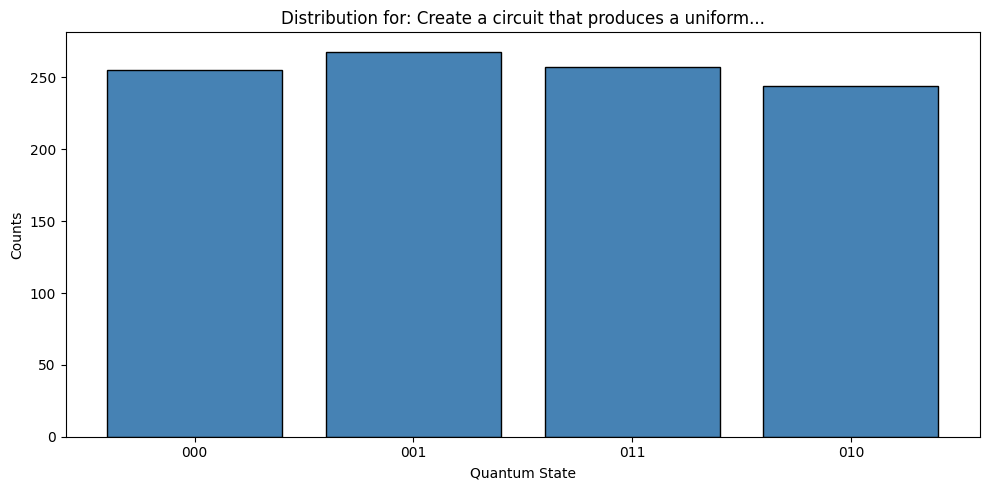

In [23]:
# Try another goal
goal2 = "Create a circuit that produces a uniform superposition over 3 qubits with phase differences"

spec2, qc2, counts2, critique2 = discovery_step(goal2)

print("\n" + "="*60)
print("📊 RESULTS")
print("="*60)
print("\n🔹 Measurement Counts:")
print(counts2)
print("\n🔹 Critique:")
print(critique2)

# Visualize
plot_counts(counts2, f"Distribution for: {goal2[:40]}...")

## Iterative Refinement

Use the critique to generate an improved circuit!

🔄 Refining circuit for: Generate high-entropy measurement distributions us...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:48:36-INFO ======
SUCCESS


  0%|          | 0/2 [00:36<?, ?it/s]

✅ Refined Circuit:
     ┌───┐┌───┐         
q_0: ┤ H ├┤ X ├─────────
     └───┘└─┬─┘┌───────┐
q_1: ───────■──┤ Rz(π) ├
               └───────┘

🔹 Refined Measurement Counts:
{'00': 510, '01': 514}


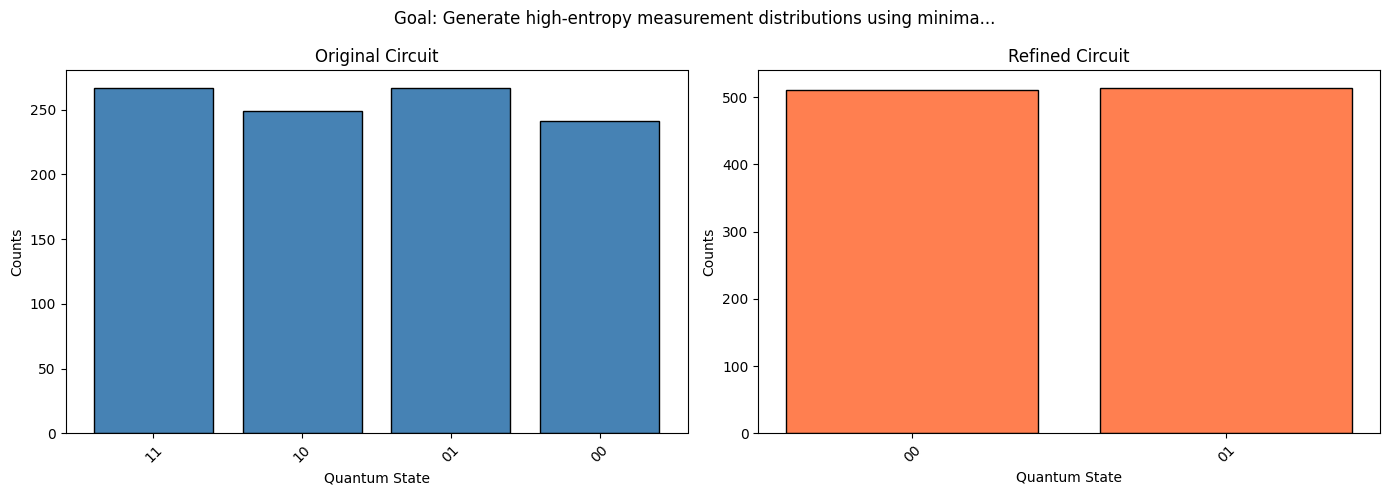

In [24]:
def refine_circuit(original_spec: dict, critique: str, goal: str) -> tuple:
    """Refine a circuit based on critique feedback."""
    
    refinement_prompt = f"""{GENERATOR_SYSTEM_PROMPT}

Original goal: {goal}

Original circuit:
{json.dumps(original_spec, indent=2)}

Critique feedback:
{critique}

Based on this critique, design an IMPROVED quantum circuit that addresses the feedback.
Keep the same goal but make the circuit better.

Respond with JSON only."""
    
    response = session.instruct(refinement_prompt)
    
    try:
        json_str = extract_json(str(response))
        new_spec = json.loads(json_str)
        new_qc = build_qiskit_circuit(new_spec)
        new_counts = simulate_circuit(new_qc)
        return new_spec, new_qc, new_counts
    except Exception as e:
        print(f"Refinement failed: {e}")
        return original_spec, None, None

# ============================================================
# Choose which example to refine (change these to use goal2, spec2, etc.)
# ============================================================
refine_goal = goal  # Use goal2 to refine the second example
refine_spec = spec  # Use spec2 to refine the second example
refine_critique = critique  # Use critique2 to refine the second example
refine_counts = counts  # Use counts2 to refine the second example

print(f"🔄 Refining circuit for: {refine_goal[:50]}...\n")
refined_spec, refined_qc, refined_counts = refine_circuit(refine_spec, refine_critique, refine_goal)

if refined_qc:
    print("✅ Refined Circuit:")
    print(refined_qc.draw(output='text'))
    print("\n🔹 Refined Measurement Counts:")
    print(refined_counts)
    
    # Compare original vs refined
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Original
    states1 = list(refine_counts.keys())
    values1 = list(refine_counts.values())
    axes[0].bar(states1, values1, color='steelblue', edgecolor='black')
    axes[0].set_title('Original Circuit')
    axes[0].set_xlabel('Quantum State')
    axes[0].set_ylabel('Counts')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Refined
    states2 = list(refined_counts.keys())
    values2 = list(refined_counts.values())
    axes[1].bar(states2, values2, color='coral', edgecolor='black')
    axes[1].set_title('Refined Circuit')
    axes[1].set_xlabel('Quantum State')
    axes[1].set_ylabel('Counts')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.suptitle(f"Goal: {refine_goal[:60]}...")
    plt.tight_layout()
    plt.show()
else:
    print("❌ Refinement failed - using original circuit")

---

## 🤖 Autonomous Discovery Mode

Now let's make the agent fully autonomous: it proposes its own research goals and iterates until success!

In [26]:
# Goal Proposer - Agent suggests novel quantum computing research objectives
GOAL_PROPOSER_PROMPT = """
You are a quantum computing research director proposing novel discovery objectives.

Propose a specific, measurable quantum circuit discovery goal that:
- Is achievable with 2-5 qubits and ≤12 gates
- Has clear success criteria (e.g., "achieve >90% probability on target state")
- Explores interesting quantum phenomena (entanglement, interference, superposition)
- Is NOT a standard textbook example (Bell state, GHZ, basic QFT)

Respond in JSON only:
{
  "goal": "Brief description of the discovery objective",
  "success_criteria": {
    "metric": "what to measure (e.g., 'entropy', 'target_probability', 'state_distribution')",
    "target_value": <number or description>,
    "comparison": ">" or "<" or "==" or "approx"
  },
  "max_iterations": 3-5,
  "rationale": "Why this is an interesting quantum computing challenge"
}
"""

def propose_goal() -> dict:
    """Have the agent propose a novel discovery goal."""
    response = session.instruct(GOAL_PROPOSER_PROMPT)
    try:
        json_str = extract_json(str(response))
        return json.loads(json_str)
    except:
        # Fallback goal
        return {
            "goal": "Create a circuit that produces maximum entropy across 3 qubits",
            "success_criteria": {
                "metric": "entropy",
                "target_value": 2.5,
                "comparison": ">"
            },
            "max_iterations": 4,
            "rationale": "High entropy indicates good quantum randomness"
        }

print("🎯 Goal Proposer ready!")

🎯 Goal Proposer ready!


In [30]:
# Success evaluation functions
def compute_entropy(counts: dict, shots: int = 1024) -> float:
    """Compute Shannon entropy of measurement distribution."""
    probs = [c / shots for c in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    return entropy

def parse_target_value(target) -> float:
    """Parse target value - handles strings like '2.5', 'high', etc."""
    if isinstance(target, (int, float)):
        return float(target)
    if isinstance(target, str):
        # Try to parse as number
        try:
            return float(target)
        except ValueError:
            pass
        # Handle descriptive targets
        target_lower = target.lower()
        if 'high' in target_lower or 'max' in target_lower:
            return 2.5  # High entropy target
        elif 'low' in target_lower or 'min' in target_lower:
            return 0.5  # Low entropy target
        elif 'uniform' in target_lower:
            return 2.0
        else:
            return 2.0  # Default
    return 2.0  # Fallback default

def evaluate_success(counts: dict, criteria: dict) -> tuple[bool, float]:
    """Evaluate if the circuit meets the success criteria."""
    metric = criteria.get("metric", "entropy")
    target = parse_target_value(criteria.get("target_value", 2.0))
    comparison = criteria.get("comparison", ">")
    
    # Calculate the metric
    if metric == "entropy":
        value = compute_entropy(counts)
    elif metric == "num_states":
        value = float(len(counts))
    elif metric == "max_probability":
        value = max(counts.values()) / sum(counts.values())
    elif metric == "uniformity":
        # How uniform is the distribution (1.0 = perfectly uniform)
        probs = list(counts.values())
        mean_prob = sum(probs) / len(probs)
        variance = sum((p - mean_prob)**2 for p in probs) / len(probs)
        value = 1.0 / (1.0 + variance / (mean_prob**2))
    else:
        value = compute_entropy(counts)  # Default to entropy
    
    # Evaluate comparison
    if comparison == ">":
        success = value > target
    elif comparison == "<":
        success = value < target
    elif comparison == ">=":
        success = value >= target
    elif comparison == "<=":
        success = value <= target
    elif comparison == "approx":
        success = abs(value - target) < 0.1 * target
    else:
        success = value == target
    
    return success, value

print("📊 Success evaluator ready!")

📊 Success evaluator ready!


In [28]:
def autonomous_discovery(proposed_goal: dict = None, verbose: bool = True):
    """
    Fully autonomous discovery loop:
    1. Agent proposes a goal (or uses provided goal)
    2. Generates circuit
    3. Evaluates against success criteria
    4. Refines until success or max iterations
    """
    # Step 1: Get or propose goal
    if proposed_goal is None:
        print("🧠 Agent proposing research goal...\n")
        goal_spec = propose_goal()
    else:
        goal_spec = proposed_goal
    
    goal = goal_spec["goal"]
    criteria = goal_spec["success_criteria"]
    max_iters = goal_spec.get("max_iterations", 4)
    
    print("="*70)
    print("🎯 AUTONOMOUS DISCOVERY SESSION")
    print("="*70)
    print(f"\n📋 Goal: {goal}")
    print(f"📏 Success Criteria: {criteria['metric']} {criteria['comparison']} {criteria['target_value']}")
    print(f"🔄 Max Iterations: {max_iters}")
    print(f"💡 Rationale: {goal_spec.get('rationale', 'N/A')}")
    print("="*70)
    
    # Track history
    history = []
    best_result = None
    best_value = float('-inf') if criteria.get("comparison", ">") in [">", ">="] else float('inf')
    
    current_spec = None
    current_critique = None
    
    for iteration in range(1, max_iters + 1):
        print(f"\n{'─'*60}")
        print(f"🔄 ITERATION {iteration}/{max_iters}")
        print(f"{'─'*60}")
        
        # Generate or refine circuit
        if iteration == 1:
            print("\n🔧 Generating initial circuit...")
            circuit_json = generate_circuit(goal)
        else:
            print("\n🔧 Refining circuit based on feedback...")
            refinement_prompt = f"""{GENERATOR_SYSTEM_PROMPT}

Goal: {goal}
Success criteria: {criteria['metric']} {criteria['comparison']} {criteria['target_value']}
Current value: {current_value:.3f}

Previous circuit:
{json.dumps(current_spec, indent=2)}

Critique:
{current_critique}

Design an IMPROVED circuit to better achieve the goal. Respond with JSON only."""
            circuit_json = str(session.instruct(refinement_prompt))
        
        # Parse circuit
        try:
            json_str = extract_json(circuit_json)
            current_spec = json.loads(json_str)
            if verbose:
                print(f"✅ Parsed: {current_spec.get('num_qubits', '?')} qubits, {len(current_spec.get('gates', []))} gates")
        except Exception as e:
            print(f"❌ Parse error: {e}")
            continue
        
        # Build and simulate
        try:
            qc = build_qiskit_circuit(current_spec)
            counts = simulate_circuit(qc)
            if verbose:
                print(f"📊 States observed: {len(counts)}")
        except Exception as e:
            print(f"❌ Simulation error: {e}")
            continue
        
        # Evaluate
        success, current_value = evaluate_success(counts, criteria)
        
        # Track best
        is_better = (criteria.get("comparison", ">") in [">", ">="] and current_value > best_value) or \
                    (criteria.get("comparison", ">") in ["<", "<="] and current_value < best_value)
        if is_better or best_result is None:
            best_value = current_value
            best_result = {
                "spec": current_spec,
                "qc": qc,
                "counts": counts,
                "iteration": iteration
            }
        
        # Log
        status = "✅ SUCCESS" if success else "⏳ Continue"
        print(f"\n📈 {criteria['metric']}: {current_value:.3f} (target: {criteria['comparison']} {criteria['target_value']}) → {status}")
        
        history.append({
            "iteration": iteration,
            "value": current_value,
            "success": success,
            "num_states": len(counts)
        })
        
        # Check success
        if success:
            print(f"\n🎉 GOAL ACHIEVED in {iteration} iteration(s)!")
            break
        
        # Get critique for next iteration
        current_critique = critique_circuit(current_spec, counts)
        if verbose:
            print(f"\n📝 Critique received for next iteration")
    
    else:
        print(f"\n⚠️ Max iterations reached. Best value: {best_value:.3f}")
    
    return {
        "goal_spec": goal_spec,
        "best_result": best_result,
        "history": history,
        "achieved": history[-1]["success"] if history else False
    }

print("🤖 Autonomous discovery loop ready!")

🤖 Autonomous discovery loop ready!


### Run Autonomous Discovery

The agent will propose its own goal and iterate until success!

🧠 Agent proposing research goal...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:56:06-INFO ======
SUCCESS


  0%|          | 0/2 [00:16<?, ?it/s]


🎯 AUTONOMOUS DISCOVERY SESSION

📋 Goal: Investigate a novel 2-qubit quantum circuit to generate a non-trivial entangled state with controllable interference patterns.
📏 Success Criteria: target_probability > >95%
🔄 Max Iterations: 5
💡 Rationale: This goal explores the generation of non-trivial entangled states using a minimal number of qubits (2), which is crucial for understanding the foundations of quantum computing and quantum information processing. The controllable interference patterns in these states can lead to novel quantum algorithms or enhance existing ones by utilizing quantum phenomena like superposition and entanglement.

────────────────────────────────────────────────────────────
🔄 ITERATION 1/5
────────────────────────────────────────────────────────────

🔧 Generating initial circuit...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:56:18-INFO ======
SUCCESS


  0%|          | 0/2 [00:12<?, ?it/s]


✅ Parsed: 2 qubits, 3 gates
📊 States observed: 2

📈 target_probability: 0.998 (target: > >95%) → ⏳ Continue


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:56:38-INFO ======
SUCCESS


  0%|          | 0/2 [00:20<?, ?it/s]



📝 Critique received for next iteration

────────────────────────────────────────────────────────────
🔄 ITERATION 2/5
────────────────────────────────────────────────────────────

🔧 Refining circuit based on feedback...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:57:10-INFO ======
SUCCESS


  0%|          | 0/2 [00:31<?, ?it/s]


✅ Parsed: 2 qubits, 4 gates
📊 States observed: 2

📈 target_probability: 0.999 (target: > >95%) → ⏳ Continue


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:57:35-INFO ======
SUCCESS


  0%|          | 0/2 [00:25<?, ?it/s]



📝 Critique received for next iteration

────────────────────────────────────────────────────────────
🔄 ITERATION 3/5
────────────────────────────────────────────────────────────

🔧 Refining circuit based on feedback...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:58:07-INFO ======
SUCCESS


  0%|          | 0/2 [00:31<?, ?it/s]


✅ Parsed: 2 qubits, 4 gates
📊 States observed: 2

📈 target_probability: 0.998 (target: > >95%) → ⏳ Continue


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:58:31-INFO ======
SUCCESS


  0%|          | 0/2 [00:24<?, ?it/s]



📝 Critique received for next iteration

────────────────────────────────────────────────────────────
🔄 ITERATION 4/5
────────────────────────────────────────────────────────────

🔧 Refining circuit based on feedback...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:59:01-INFO ======
SUCCESS


  0%|          | 0/2 [00:29<?, ?it/s]


✅ Parsed: 2 qubits, 4 gates
📊 States observed: 2

📈 target_probability: 1.000 (target: > >95%) → ⏳ Continue


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:59:22-INFO ======
SUCCESS


  0%|          | 0/2 [00:20<?, ?it/s]



📝 Critique received for next iteration

────────────────────────────────────────────────────────────
🔄 ITERATION 5/5
────────────────────────────────────────────────────────────

🔧 Refining circuit based on feedback...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:59:48-INFO ======
SUCCESS


  0%|          | 0/2 [00:26<?, ?it/s]


✅ Parsed: 2 qubits, 3 gates
📊 States observed: 2

📈 target_probability: 1.000 (target: > >95%) → ⏳ Continue


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:00:08-INFO ======
SUCCESS


  0%|          | 0/2 [00:20<?, ?it/s]


📝 Critique received for next iteration

⚠️ Max iterations reached. Best value: 1.000

🏆 FINAL RESULTS

🔹 Best Circuit (from iteration 4):
     ┌───┐               
q_0: ┤ H ├─■───────────■─
     └───┘ │ ┌───────┐ │ 
q_1: ──────■─┤ Rz(π) ├─■─
             └───────┘   

🔹 Final Measurement Distribution:
{'01': 520, '00': 504}


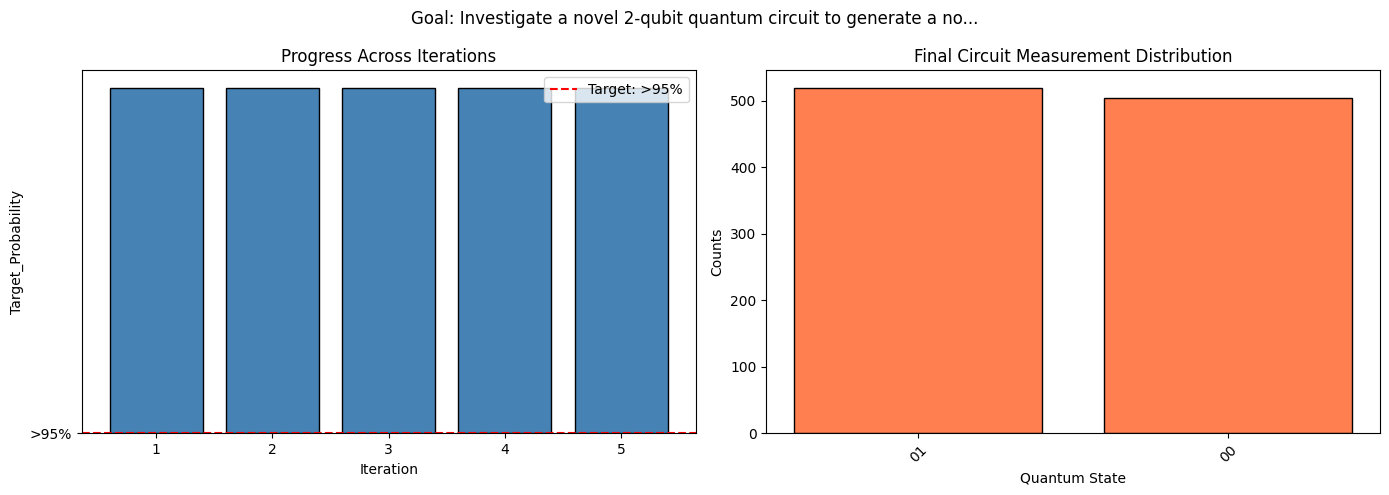

In [31]:
# Let the agent propose and achieve its own goal!
session.reset()
result = autonomous_discovery()

# Show final results
if result["best_result"]:
    print("\n" + "="*70)
    print("🏆 FINAL RESULTS")
    print("="*70)
    
    best = result["best_result"]
    print(f"\n🔹 Best Circuit (from iteration {best['iteration']}):")
    print(best["qc"].draw(output='text'))
    
    print(f"\n🔹 Final Measurement Distribution:")
    print(best["counts"])
    
    # Plot progress
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Progress chart
    iterations = [h["iteration"] for h in result["history"]]
    values = [h["value"] for h in result["history"]]
    colors = ['green' if h["success"] else 'steelblue' for h in result["history"]]
    
    axes[0].bar(iterations, values, color=colors, edgecolor='black')
    target = result["goal_spec"]["success_criteria"]["target_value"]
    axes[0].axhline(y=target, color='red', linestyle='--', label=f'Target: {target}')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel(result["goal_spec"]["success_criteria"]["metric"].title())
    axes[0].set_title('Progress Across Iterations')
    axes[0].legend()
    
    # Final distribution
    states = list(best["counts"].keys())
    counts_vals = list(best["counts"].values())
    axes[1].bar(states, counts_vals, color='coral', edgecolor='black')
    axes[1].set_xlabel('Quantum State')
    axes[1].set_ylabel('Counts')
    axes[1].set_title('Final Circuit Measurement Distribution')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.suptitle(f"Goal: {result['goal_spec']['goal'][:60]}...")
    plt.tight_layout()
    plt.show()

### Custom Goal Example

You can also provide a specific goal for the agent to achieve:

🎯 AUTONOMOUS DISCOVERY SESSION

📋 Goal: Create a 4-qubit circuit where all 16 states have roughly equal probability
📏 Success Criteria: entropy > 3.5
🔄 Max Iterations: 4
💡 Rationale: Testing ability to create uniform superposition across 4 qubits

────────────────────────────────────────────────────────────
🔄 ITERATION 1/4
────────────────────────────────────────────────────────────

🔧 Generating initial circuit...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:00:22-INFO ======
SUCCESS


  0%|          | 0/2 [00:13<?, ?it/s]

✅ Parsed: 4 qubits, 4 gates
📊 States observed: 16

📈 entropy: 3.990 (target: > 3.5) → ✅ SUCCESS

🎉 GOAL ACHIEVED in 1 iteration(s)!

🔹 Best Circuit:
     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘


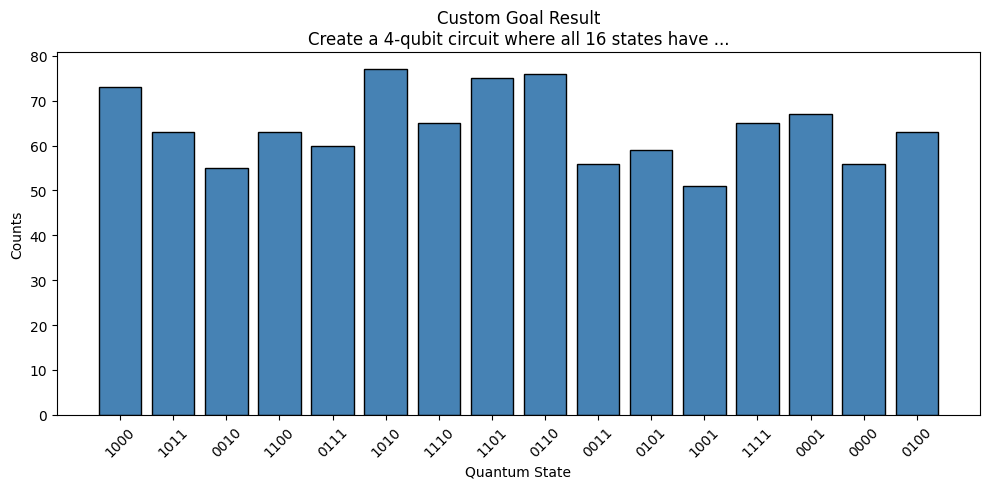

In [32]:
# Provide a custom goal
custom_goal = {
    "goal": "Create a 4-qubit circuit where all 16 states have roughly equal probability",
    "success_criteria": {
        "metric": "entropy",
        "target_value": 3.5,  # Max entropy for 4 qubits is 4.0
        "comparison": ">"
    },
    "max_iterations": 4,
    "rationale": "Testing ability to create uniform superposition across 4 qubits"
}

session.reset()
custom_result = autonomous_discovery(proposed_goal=custom_goal)

# Visualize
if custom_result["best_result"]:
    best = custom_result["best_result"]
    print(f"\n🔹 Best Circuit:")
    print(best["qc"].draw(output='text'))
    plot_counts(best["counts"], f"Custom Goal Result\n{custom_goal['goal'][:50]}...")

---

## 🔬 Robust Physics-Aware Discovery

The problem with simple metrics: an agent can "cheat" by producing trivial circuits.

**Solution**: The goal proposer must generate **problem-specific validation strategies** that require genuine quantum behavior - not just any circuit that passes a simple threshold.

In [38]:
from qiskit.quantum_info import Statevector, partial_trace, entropy, DensityMatrix
from scipy.signal import find_peaks

# =============================================================================
# PHYSICS-AWARE METRIC LIBRARY
# These are robust metrics that can't be trivially satisfied
# =============================================================================

def compute_concurrence(qc: QuantumCircuit, qubits: tuple = (0, 1)) -> float:
    """Compute concurrence (entanglement measure) for a 2-qubit subsystem.
    
    Concurrence = 0 means separable (no entanglement)
    Concurrence = 1 means maximally entangled
    """
    state = Statevector.from_instruction(qc)
    rho = DensityMatrix(state)
    
    # Trace out other qubits to get 2-qubit reduced density matrix
    n_qubits = qc.num_qubits
    trace_out = [i for i in range(n_qubits) if i not in qubits]
    
    if trace_out:
        rho_reduced = partial_trace(rho, trace_out)
    else:
        rho_reduced = rho
    
    # Compute concurrence using the formula
    rho_matrix = rho_reduced.data
    
    # Pauli Y tensor Y
    sigma_y = np.array([[0, -1j], [1j, 0]])
    yy = np.kron(sigma_y, sigma_y)
    
    # R = rho * (sigma_y ⊗ sigma_y) * rho* * (sigma_y ⊗ sigma_y)
    rho_tilde = yy @ rho_matrix.conj() @ yy
    R = rho_matrix @ rho_tilde
    
    # Eigenvalues of R
    eigenvalues = np.sort(np.real(np.sqrt(np.maximum(np.linalg.eigvals(R), 0))))[::-1]
    
    concurrence = max(0, eigenvalues[0] - eigenvalues[1] - eigenvalues[2] - eigenvalues[3])
    return float(concurrence)


def compute_entanglement_entropy(qc: QuantumCircuit, subsystem: list = [0]) -> float:
    """Compute Von Neumann entropy of a subsystem (entanglement entropy).
    
    For a pure state, non-zero entropy of subsystem indicates entanglement.
    """
    state = Statevector.from_instruction(qc)
    rho = DensityMatrix(state)
    
    # Trace out the complement of subsystem
    n_qubits = qc.num_qubits
    trace_out = [i for i in range(n_qubits) if i not in subsystem]
    
    if trace_out:
        rho_reduced = partial_trace(rho, trace_out)
        return float(entropy(rho_reduced, base=2))
    return 0.0


def detect_interference_oscillations(qc_spec: dict, target_state: str = "00", 
                                     param_name: str = "theta", n_points: int = 20) -> dict:
    """Sweep a rotation parameter and detect interference oscillations.
    
    Returns:
        - oscillates: bool (True if interference pattern detected)
        - num_extrema: int (number of peaks + valleys)
        - amplitude: float (peak-to-peak amplitude)
    """
    # Find the gate with the parameter
    param_gate_idx = None
    for i, gate in enumerate(qc_spec.get("gates", [])):
        if gate.get("name", "").lower() in ["rx", "ry", "rz"]:
            param_gate_idx = i
            break
    
    if param_gate_idx is None:
        return {"oscillates": False, "num_extrema": 0, "amplitude": 0.0, "reason": "no_param_gate"}
    
    # Sweep theta from 0 to 2*pi
    theta_values = np.linspace(0, 2 * np.pi, n_points)
    probabilities = []
    
    for theta in theta_values:
        # Create modified spec with this theta value
        modified_spec = json.loads(json.dumps(qc_spec))  # Deep copy
        modified_spec["gates"][param_gate_idx]["theta"] = theta
        
        try:
            qc = build_qiskit_circuit(modified_spec)
            state = Statevector.from_instruction(qc)
            probs = state.probabilities_dict()
            probabilities.append(probs.get(target_state, 0.0))
        except:
            probabilities.append(0.0)
    
    probabilities = np.array(probabilities)
    
    # Detect peaks and valleys
    peaks, _ = find_peaks(probabilities, prominence=0.05)
    valleys, _ = find_peaks(-probabilities, prominence=0.05)
    
    num_extrema = len(peaks) + len(valleys)
    amplitude = float(np.max(probabilities) - np.min(probabilities))
    oscillates = num_extrema >= 2 and amplitude > 0.2
    
    return {
        "oscillates": oscillates,
        "num_extrema": num_extrema,
        "amplitude": amplitude,
        "probabilities": probabilities.tolist(),
        "theta_values": theta_values.tolist()
    }


def sweep_metric_over_parameter(qc_spec: dict, metric_fn: callable, metric_name: str = "metric",
                                 n_points: int = 20) -> dict:
    """Sweep a rotation parameter and track ANY metric over the sweep.
    
    This is the generalized version that can track concurrence, entropy, etc.
    Returns detailed sweep results including extrema detection.
    """
    # Find a rotation gate to sweep
    param_gate_idx = None
    for i, gate in enumerate(qc_spec.get("gates", [])):
        if gate.get("name", "").lower() in ["rx", "ry", "rz"]:
            param_gate_idx = i
            break
    
    if param_gate_idx is None:
        return {
            "sweep_performed": False,
            "reason": "no_rotation_gate",
            "num_extrema": 0,
            "amplitude": 0.0,
            "values": [],
            "theta_values": []
        }
    
    # Sweep theta from 0 to 2*pi
    theta_values = np.linspace(0, 2 * np.pi, n_points)
    metric_values = []
    
    for theta in theta_values:
        # Create modified spec with this theta value
        modified_spec = json.loads(json.dumps(qc_spec))  # Deep copy
        modified_spec["gates"][param_gate_idx]["theta"] = float(theta)
        
        try:
            qc = build_qiskit_circuit(modified_spec)
            value = metric_fn(qc)
            metric_values.append(float(value))
        except Exception as e:
            metric_values.append(0.0)
    
    metric_values = np.array(metric_values)
    
    # Detect peaks and valleys (extrema)
    peaks, peak_props = find_peaks(metric_values, prominence=0.02)
    valleys, valley_props = find_peaks(-metric_values, prominence=0.02)
    
    num_extrema = len(peaks) + len(valleys)
    amplitude = float(np.max(metric_values) - np.min(metric_values))
    mean_value = float(np.mean(metric_values))
    max_value = float(np.max(metric_values))
    min_value = float(np.min(metric_values))
    
    return {
        "sweep_performed": True,
        "metric_name": metric_name,
        "num_extrema": num_extrema,
        "num_peaks": len(peaks),
        "num_valleys": len(valleys),
        "amplitude": amplitude,
        "mean_value": mean_value,
        "max_value": max_value,
        "min_value": min_value,
        "values": metric_values.tolist(),
        "theta_values": theta_values.tolist(),
        "peak_thetas": [theta_values[i] for i in peaks],
        "valley_thetas": [theta_values[i] for i in valleys]
    }


def measure_in_multiple_bases(qc: QuantumCircuit, shots: int = 1024) -> dict:
    """Measure circuit in Z, X, and Y bases.
    
    Genuine quantum states show different distributions in different bases.
    Classical states look the same in all bases.
    """
    sim = AerSimulator()
    results = {}
    
    # Z basis (standard)
    qc_z = qc.copy()
    qc_z.measure_all()
    job = sim.run(qc_z, shots=shots)
    results["Z"] = job.result().get_counts()
    
    # X basis (apply H before measurement)
    qc_x = qc.copy()
    for i in range(qc.num_qubits):
        qc_x.h(i)
    qc_x.measure_all()
    job = sim.run(qc_x, shots=shots)
    results["X"] = job.result().get_counts()
    
    # Y basis (apply S†H before measurement)
    qc_y = qc.copy()
    for i in range(qc.num_qubits):
        qc_y.sdg(i)
        qc_y.h(i)
    qc_y.measure_all()
    job = sim.run(qc_y, shots=shots)
    results["Y"] = job.result().get_counts()
    
    # Compute basis-dependence score (how different are the distributions?)
    def distribution_entropy(counts):
        total = sum(counts.values())
        return -sum((c/total) * np.log2(c/total) for c in counts.values() if c > 0)
    
    entropies = {basis: distribution_entropy(counts) for basis, counts in results.items()}
    basis_variation = np.std(list(entropies.values()))
    
    return {
        "counts": results,
        "entropies": entropies,
        "basis_variation": float(basis_variation),
        "is_quantum": basis_variation > 0.1 or any(e > 0.5 for e in entropies.values())
    }


print("🔬 Physics-aware metric library loaded!")

🔬 Physics-aware metric library loaded!


In [42]:
# =============================================================================
# EXPERT GOAL PROPOSER - Generates goals WITH robust validation strategies
# =============================================================================

EXPERT_GOAL_PROPOSER_PROMPT = """
You are a quantum computing research director proposing novel discovery objectives.

IMPORTANT: You must propose goals that require GENUINE quantum phenomena, not trivial solutions.

Propose a specific quantum circuit discovery goal with ROBUST validation:

Categories to choose from:
1. ENTANGLEMENT: Requires measured concurrence > threshold
2. INTERFERENCE: Requires oscillating probability under parameter sweep
3. SUPERPOSITION: Requires measurement in multiple bases showing quantum behavior
4. MIXED: Combination of above (hardest)

Respond in JSON only:
{
  "goal": "Brief description of the discovery objective",
  "category": "entanglement" | "interference" | "superposition" | "mixed",
  "validation_strategy": {
    "primary_metric": "concurrence" | "entanglement_entropy" | "interference_oscillations" | "multi_basis",
    "primary_threshold": <number>,
    "secondary_metric": <optional, for mixed category>,
    "secondary_threshold": <optional>,
    "requires_parameter_sweep": true | false,
    "min_extrema_if_sweep": <number, e.g., 2 for interference>
  },
  "constraints": {
    "min_qubits": 2,
    "max_qubits": 5,
    "must_have_entangling_gate": true | false,
    "must_have_rotation_gate": true | false
  },
  "max_iterations": 4,
  "rationale": "Why this requires genuine quantum behavior and can't be trivially satisfied"
}

Examples of GOOD goals:
- "Create entanglement with concurrence > 0.7" (can't fake with product states)
- "Design interference: P(00) must oscillate with ≥3 extrema over θ∈[0,2π]"
- "Partial entanglement: entropy of qubit 0 between 0.5 and 0.9" (forces partial mixing)

Examples of BAD goals (too easy to cheat):
- "High entropy" (just apply H gates)
- "Uniform distribution" (trivial)
"""

def propose_expert_goal() -> dict:
    """Have the agent propose a goal with robust physics-aware validation."""
    response = session.instruct(EXPERT_GOAL_PROPOSER_PROMPT)
    try:
        json_str = extract_json(str(response))
        goal_spec = json.loads(json_str)
        
        # Validate required fields
        if "validation_strategy" not in goal_spec:
            raise ValueError("Missing validation_strategy")
        
        return goal_spec
    except Exception as e:
        print(f"⚠️ Goal parsing failed ({e}), using fallback expert goal")
        # Fallback: a genuinely challenging goal
        return {
            "goal": "Create a 2-qubit circuit with concurrence > 0.7 (genuine entanglement)",
            "category": "entanglement",
            "validation_strategy": {
                "primary_metric": "concurrence",
                "primary_threshold": 0.7,
                "requires_parameter_sweep": False
            },
            "constraints": {
                "min_qubits": 2,
                "max_qubits": 4,
                "must_have_entangling_gate": True,
                "must_have_rotation_gate": False
            },
            "max_iterations": 4,
            "rationale": "Concurrence > 0.7 requires genuine entanglement - can't be achieved with product states"
        }


def evaluate_expert_criteria(qc: QuantumCircuit, spec: dict, validation: dict, verbose: bool = True) -> dict:
    """Evaluate circuit against expert validation strategy.
    
    Returns detailed results for each metric, INCLUDING explicit parameter sweep results.
    """
    results = {
        "passed": False,
        "metrics": {},
        "details": {},
        "sweep_results": None  # Will contain sweep data if performed
    }
    
    primary_metric = validation.get("primary_metric", "entropy")
    primary_threshold = float(validation.get("primary_threshold", 0.5))
    requires_sweep = validation.get("requires_parameter_sweep", False)
    min_extrema = validation.get("min_extrema_if_sweep", 2)
    
    # =================================================================
    # PARAMETER SWEEP CHECK (when required)
    # This is the key robustness mechanism - we explicitly verify behavior
    # =================================================================
    sweep_passed = True  # Default to True if sweep not required
    
    if requires_sweep:
        # Determine which metric to sweep
        if primary_metric == "concurrence":
            sweep_result = sweep_metric_over_parameter(spec, compute_concurrence, "concurrence")
        elif primary_metric == "entanglement_entropy":
            sweep_result = sweep_metric_over_parameter(
                spec, 
                lambda qc: compute_entanglement_entropy(qc, subsystem=[0]), 
                "entanglement_entropy"
            )
        elif primary_metric == "interference_oscillations":
            sweep_result = detect_interference_oscillations(spec)
            # Convert to standard format
            sweep_result["sweep_performed"] = True
            sweep_result["metric_name"] = "P(target_state)"
        else:
            # Default to probability sweep
            sweep_result = detect_interference_oscillations(spec)
            sweep_result["sweep_performed"] = True
            sweep_result["metric_name"] = "P(00)"
        
        results["sweep_results"] = sweep_result
        
        # Check if sweep requirements are met
        if sweep_result.get("sweep_performed", False):
            num_extrema = sweep_result.get("num_extrema", 0)
            amplitude = sweep_result.get("amplitude", 0.0)
            mean_value = sweep_result.get("mean_value", 0.0)
            max_value = sweep_result.get("max_value", 0.0)
            
            if verbose:
                print(f"\n   🔁 Parameter Sweep Results:")
                print(f"      θ ∈ [0, 2π], {len(sweep_result.get('theta_values', []))} points")
                print(f"      {sweep_result.get('metric_name', 'metric')} extrema detected: {num_extrema}")
                print(f"      Amplitude (max-min): {amplitude:.4f}")
                print(f"      Mean value: {mean_value:.4f}, Max value: {max_value:.4f}")
                if sweep_result.get('peak_thetas'):
                    print(f"      Peak θ values: {[f'{t:.2f}' for t in sweep_result['peak_thetas'][:3]]}")
                if sweep_result.get('valley_thetas'):
                    print(f"      Valley θ values: {[f'{t:.2f}' for t in sweep_result['valley_thetas'][:3]]}")
            
            results["metrics"]["sweep_extrema"] = num_extrema
            results["metrics"]["sweep_amplitude"] = amplitude
            
            # SMART SWEEP VALIDATION:
            # For entanglement metrics (concurrence, entropy): stable high value is VALID
            # For interference metrics: oscillation is required
            if primary_metric in ["concurrence", "entanglement_entropy"]:
                # For entanglement: either oscillation OR stable high value is valid
                stable_high = mean_value >= primary_threshold and amplitude < 0.1
                has_oscillation = num_extrema >= min_extrema
                sweep_passed = stable_high or has_oscillation
                
                if verbose:
                    if stable_high:
                        print(f"      ✅ Stable entanglement: mean {mean_value:.3f} ≥ {primary_threshold} (amplitude < 0.1)")
                    elif has_oscillation:
                        print(f"      ✅ Oscillating entanglement: {num_extrema} extrema detected")
                    else:
                        print(f"      ❌ Neither stable high value nor oscillation detected")
            else:
                # For interference: oscillation is required
                sweep_passed = num_extrema >= min_extrema
                if not sweep_passed and verbose:
                    print(f"      ❌ Need ≥{min_extrema} extrema, found {num_extrema}")
                elif verbose:
                    print(f"      ✅ Sweep requirement met: {num_extrema} ≥ {min_extrema} extrema")
        else:
            if verbose:
                print(f"\n   ⚠️ Parameter sweep could not be performed: {sweep_result.get('reason', 'unknown')}")
            sweep_passed = False
    
    # =================================================================
    # PRIMARY METRIC EVALUATION
    # =================================================================
    if primary_metric == "concurrence":
        value = compute_concurrence(qc)
        results["metrics"]["concurrence"] = value
        primary_passed = value > primary_threshold
        
    elif primary_metric == "entanglement_entropy":
        value = compute_entanglement_entropy(qc, subsystem=[0])
        results["metrics"]["entanglement_entropy"] = value
        primary_passed = value > primary_threshold
        
    elif primary_metric == "interference_oscillations":
        if not requires_sweep:  # If sweep wasn't already done
            sweep_result = detect_interference_oscillations(spec)
            results["sweep_results"] = sweep_result
        else:
            sweep_result = results["sweep_results"]
        
        results["metrics"]["num_extrema"] = sweep_result.get("num_extrema", 0)
        results["metrics"]["amplitude"] = sweep_result.get("amplitude", 0.0)
        results["details"]["interference"] = sweep_result
        primary_passed = sweep_result.get("oscillates", False) and sweep_result.get("num_extrema", 0) >= min_extrema
        
    elif primary_metric == "multi_basis":
        basis_result = measure_in_multiple_bases(qc)
        results["metrics"]["basis_variation"] = basis_result["basis_variation"]
        results["details"]["multi_basis"] = basis_result
        primary_passed = basis_result["is_quantum"]
        
    else:
        # Fallback to entropy
        counts = simulate_circuit(qc)
        value = compute_entropy(counts)
        results["metrics"]["entropy"] = value
        primary_passed = value > primary_threshold
    
    results["primary_passed"] = primary_passed
    
    # =================================================================
    # SECONDARY METRIC (for mixed category)
    # =================================================================
    secondary_metric = validation.get("secondary_metric")
    if secondary_metric:
        secondary_threshold = float(validation.get("secondary_threshold", 0.5))
        
        if secondary_metric == "concurrence":
            sec_value = compute_concurrence(qc)
            results["metrics"]["secondary_concurrence"] = sec_value
            secondary_passed = sec_value > secondary_threshold
        elif secondary_metric == "entanglement_entropy":
            sec_value = compute_entanglement_entropy(qc)
            results["metrics"]["secondary_entropy"] = sec_value
            secondary_passed = sec_value > secondary_threshold
        else:
            secondary_passed = True
        
        results["secondary_passed"] = secondary_passed
        results["passed"] = primary_passed and secondary_passed and sweep_passed
    else:
        results["passed"] = primary_passed and sweep_passed
    
    # Add sweep pass status to results
    results["sweep_passed"] = sweep_passed
    
    return results


print("🎯 Expert goal proposer ready!")

🎯 Expert goal proposer ready!


In [43]:
def robust_autonomous_discovery(proposed_goal: dict = None, verbose: bool = True):
    """
    Autonomous discovery with ROBUST physics-aware validation.
    
    The agent can't cheat - must produce genuine quantum circuits.
    """
    # Step 1: Get or propose expert goal
    if proposed_goal is None:
        print("🧠 Agent proposing expert research goal...\n")
        goal_spec = propose_expert_goal()
    else:
        goal_spec = proposed_goal
    
    goal = goal_spec["goal"]
    category = goal_spec.get("category", "unknown")
    validation = goal_spec.get("validation_strategy", {})
    constraints = goal_spec.get("constraints", {})
    max_iters = goal_spec.get("max_iterations", 4)
    
    print("="*70)
    print("🔬 ROBUST AUTONOMOUS DISCOVERY SESSION")
    print("="*70)
    print(f"\n📋 Goal: {goal}")
    print(f"📁 Category: {category.upper()}")
    print(f"🔍 Primary Metric: {validation.get('primary_metric')} > {validation.get('primary_threshold')}")
    if validation.get('secondary_metric'):
        print(f"🔍 Secondary Metric: {validation.get('secondary_metric')} > {validation.get('secondary_threshold')}")
    if validation.get('requires_parameter_sweep'):
        print(f"📈 Requires Parameter Sweep: Yes (min {validation.get('min_extrema_if_sweep', 2)} extrema)")
    print(f"🔄 Max Iterations: {max_iters}")
    print(f"💡 Rationale: {goal_spec.get('rationale', 'N/A')}")
    print("="*70)
    
    # Build constraint description for the generator
    constraint_desc = []
    if constraints.get("must_have_entangling_gate"):
        constraint_desc.append("MUST include at least one CX or CZ gate")
    if constraints.get("must_have_rotation_gate"):
        constraint_desc.append("MUST include at least one RX, RY, or RZ gate with a theta parameter")
    constraint_str = ". ".join(constraint_desc) if constraint_desc else ""
    
    # Track history
    history = []
    best_result = None
    best_score = 0.0
    
    current_spec = None
    current_critique = None
    
    for iteration in range(1, max_iters + 1):
        print(f"\n{'─'*60}")
        print(f"🔄 ITERATION {iteration}/{max_iters}")
        print(f"{'─'*60}")
        
        # Generate or refine circuit with constraints
        if iteration == 1:
            print("\n🔧 Generating initial circuit...")
            enhanced_prompt = f"""{GENERATOR_SYSTEM_PROMPT}

Task: {goal}

CRITICAL REQUIREMENTS:
{constraint_str}
- This goal requires GENUINE quantum phenomena
- Metric: {validation.get('primary_metric')} must exceed {validation.get('primary_threshold')}

Respond with valid JSON only."""
            circuit_json = str(session.instruct(enhanced_prompt))
        else:
            print("\n🔧 Refining circuit based on physics feedback...")
            refinement_prompt = f"""{GENERATOR_SYSTEM_PROMPT}

Goal: {goal}

CRITICAL: The circuit must pass physics validation:
- Metric: {validation.get('primary_metric')}
- Current value: {eval_results['metrics']}
- Target: > {validation.get('primary_threshold')}
- Status: {'PASSED' if eval_results['passed'] else 'FAILED - needs improvement'}

{constraint_str}

Previous circuit:
{json.dumps(current_spec, indent=2)}

Critique:
{current_critique}

Design an IMPROVED circuit. You MUST create genuine quantum effects.
Respond with JSON only."""
            circuit_json = str(session.instruct(refinement_prompt))
        
        # Parse circuit
        try:
            json_str = extract_json(circuit_json)
            current_spec = json.loads(json_str)
            if verbose:
                print(f"✅ Parsed: {current_spec.get('num_qubits', '?')} qubits, {len(current_spec.get('gates', []))} gates")
        except Exception as e:
            print(f"❌ Parse error: {e}")
            continue
        
        # Validate constraints
        gates = current_spec.get("gates", [])
        gate_names = [g.get("name", "").lower() for g in gates]
        
        if constraints.get("must_have_entangling_gate"):
            if not any(g in ["cx", "cz", "cnot"] for g in gate_names):
                print(f"⚠️ Missing required entangling gate - adding CX")
                current_spec["gates"].append({"name": "cx", "control": 0, "target": 1})
        
        if constraints.get("must_have_rotation_gate"):
            if not any(g in ["rx", "ry", "rz"] for g in gate_names):
                print(f"⚠️ Missing required rotation gate - adding RZ")
                current_spec["gates"].append({"name": "rz", "targets": [0], "theta": "pi/4"})
        
        # Build and evaluate with physics metrics
        try:
            qc = build_qiskit_circuit(current_spec)
            counts = simulate_circuit(qc)
            if verbose:
                print(f"📊 States observed: {len(counts)}")
            
            # Physics-aware evaluation (verbose=True to show sweep details inline)
            eval_results = evaluate_expert_criteria(qc, current_spec, validation, verbose=verbose)
            
            if verbose:
                print(f"\n🔬 Physics Metrics:")
                for metric, value in eval_results["metrics"].items():
                    print(f"   • {metric}: {value:.4f}")
                
        except Exception as e:
            print(f"❌ Evaluation error: {e}")
            import traceback
            traceback.print_exc()
            continue
        
        # Calculate score for tracking best
        score = sum(eval_results["metrics"].values()) / len(eval_results["metrics"]) if eval_results["metrics"] else 0
        
        if score > best_score or best_result is None:
            best_score = score
            best_result = {
                "spec": current_spec,
                "qc": qc,
                "counts": counts,
                "iteration": iteration,
                "eval_results": eval_results
            }
        
        # Log
        status = "✅ PASSED" if eval_results["passed"] else "❌ FAILED"
        print(f"\n📈 Validation: {status}")
        
        history.append({
            "iteration": iteration,
            "metrics": eval_results["metrics"].copy(),
            "passed": eval_results["passed"],
            "num_states": len(counts)
        })
        
        # Check success
        if eval_results["passed"]:
            print(f"\n🎉 PHYSICS VALIDATION PASSED in {iteration} iteration(s)!")
            print("   This circuit exhibits genuine quantum behavior!")
            break
        
        # Get critique for next iteration
        current_critique = critique_circuit(current_spec, counts)
        # Add physics feedback to critique
        current_critique += f"\n\nPHYSICS FEEDBACK: {validation.get('primary_metric')} = {list(eval_results['metrics'].values())[0] if eval_results['metrics'] else 'N/A'}, need > {validation.get('primary_threshold')}"
        
        if verbose:
            print(f"\n📝 Critique + physics feedback prepared for next iteration")
    
    else:
        print(f"\n⚠️ Max iterations reached. Best metrics: {best_result['eval_results']['metrics'] if best_result else 'None'}")
    
    return {
        "goal_spec": goal_spec,
        "best_result": best_result,
        "history": history,
        "achieved": history[-1]["passed"] if history else False
    }

print("🤖 Robust autonomous discovery ready!")

🤖 Robust autonomous discovery ready!


### Run Robust Discovery

Let the agent propose a physics-aware goal with non-cheatable validation:

🧠 Agent proposing expert research goal...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:27:29-INFO ======
SUCCESS


  0%|          | 0/2 [01:11<?, ?it/s]


🔬 ROBUST AUTONOMOUS DISCOVERY SESSION

📋 Goal: Discover a quantum circuit with strong entanglement exhibiting concurrence > 0.8
📁 Category: ENTANGLEMENT
🔍 Primary Metric: concurrence > 0.8
📈 Requires Parameter Sweep: Yes (min 2 extrema)
🔄 Max Iterations: 4
💡 Rationale: This goal requires genuine entanglement beyond simple product states. It necessitates a parameter sweep to determine oscillations in concurrence, verifying the degree of entanglement and ruling out trivial solutions.

────────────────────────────────────────────────────────────
🔄 ITERATION 1/4
────────────────────────────────────────────────────────────

🔧 Generating initial circuit...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:27:50-INFO ======
SUCCESS


  0%|          | 0/2 [00:21<?, ?it/s]


✅ Parsed: 2 qubits, 2 gates
📊 States observed: 1

   🔁 Parameter Sweep Results:
      θ ∈ [0, 2π], 20 points
      concurrence extrema detected: 0
      Amplitude (max-min): 0.0000
      Mean value: 0.0000, Max value: 0.0000
      ❌ Neither stable high value nor oscillation detected

🔬 Physics Metrics:
   • sweep_extrema: 0.0000
   • sweep_amplitude: 0.0000
   • concurrence: 0.0000

📈 Validation: ❌ FAILED


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:28:21-INFO ======
SUCCESS


  0%|          | 0/2 [00:30<?, ?it/s]



📝 Critique + physics feedback prepared for next iteration

────────────────────────────────────────────────────────────
🔄 ITERATION 2/4
────────────────────────────────────────────────────────────

🔧 Refining circuit based on physics feedback...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:29:25-INFO ======
SUCCESS


  0%|          | 0/2 [01:03<?, ?it/s]


✅ Parsed: 2 qubits, 2 gates
📊 States observed: 2

   🔁 Parameter Sweep Results:
      θ ∈ [0, 2π], 20 points
      concurrence extrema detected: 0
      Amplitude (max-min): 0.0000
      Mean value: 0.0000, Max value: 0.0000
      ❌ Neither stable high value nor oscillation detected

🔬 Physics Metrics:
   • sweep_extrema: 0.0000
   • sweep_amplitude: 0.0000
   • concurrence: 0.0000

📈 Validation: ❌ FAILED


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:30:00-INFO ======
SUCCESS


  0%|          | 0/2 [00:35<?, ?it/s]



📝 Critique + physics feedback prepared for next iteration

────────────────────────────────────────────────────────────
🔄 ITERATION 3/4
────────────────────────────────────────────────────────────

🔧 Refining circuit based on physics feedback...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:31:29-INFO ======
SUCCESS


  0%|          | 0/2 [01:28<?, ?it/s]


✅ Parsed: 2 qubits, 3 gates
📊 States observed: 2

   🔁 Parameter Sweep Results:
      θ ∈ [0, 2π], 20 points
      concurrence extrema detected: 0
      Amplitude (max-min): 0.0000
      Mean value: 0.0000, Max value: 0.0000
      ❌ Neither stable high value nor oscillation detected

🔬 Physics Metrics:
   • sweep_extrema: 0.0000
   • sweep_amplitude: 0.0000
   • concurrence: 0.0000

📈 Validation: ❌ FAILED


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:32:45-INFO ======
SUCCESS


  0%|          | 0/2 [01:15<?, ?it/s]



📝 Critique + physics feedback prepared for next iteration

────────────────────────────────────────────────────────────
🔄 ITERATION 4/4
────────────────────────────────────────────────────────────

🔧 Refining circuit based on physics feedback...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:34:12-INFO ======
SUCCESS


  0%|          | 0/2 [01:27<?, ?it/s]


✅ Parsed: 2 qubits, 4 gates
📊 States observed: 2

   🔁 Parameter Sweep Results:
      θ ∈ [0, 2π], 20 points
      concurrence extrema detected: 0
      Amplitude (max-min): 0.0000
      Mean value: 0.0000, Max value: 0.0000
      ❌ Neither stable high value nor oscillation detected

🔬 Physics Metrics:
   • sweep_extrema: 0.0000
   • sweep_amplitude: 0.0000
   • concurrence: 0.0000

📈 Validation: ❌ FAILED


  0%|          | 0/2 [00:00<?, ?it/s]

=== 15:35:54-INFO ======
SUCCESS


  0%|          | 0/2 [01:41<?, ?it/s]


📝 Critique + physics feedback prepared for next iteration

⚠️ Max iterations reached. Best metrics: {'sweep_extrema': 0, 'sweep_amplitude': 0.0, 'concurrence': 0.0}

🏆 ROBUST DISCOVERY RESULTS

🔹 Best Circuit (from iteration 1):
                     
q_0: ──■─────────────
     ┌─┴─┐┌─────────┐
q_1: ┤ X ├┤ Rz(π/2) ├
     └───┘└─────────┘

🔬 Physics Validation Results:
   ❌ sweep_extrema: 0.0000 (threshold: 0.8)
   ❌ sweep_amplitude: 0.0000 (threshold: 0.8)
   ❌ concurrence: 0.0000 (threshold: 0.8)

🔁 Parameter Sweep Summary:
   θ ∈ [0, 2π]
   concurrence extrema detected: 0
   Amplitude (max-min): 0.0000
   Sweep requirement (≥2 extrema): ❌ FAILED


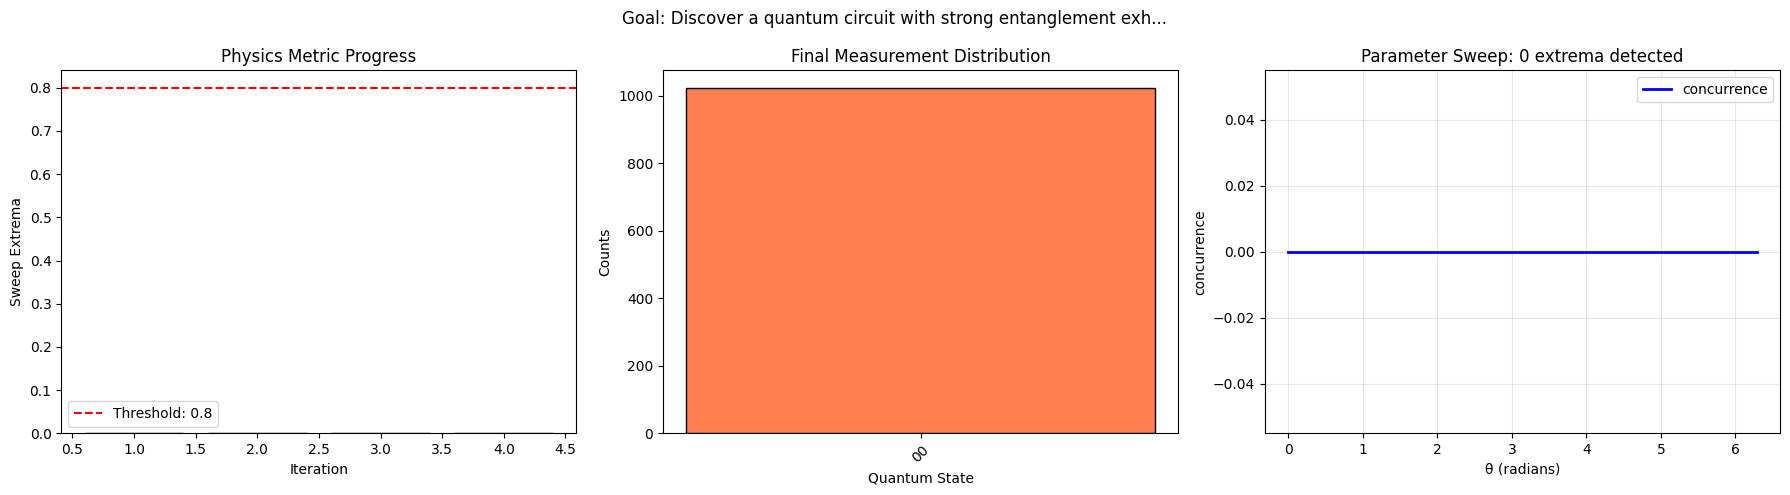

In [46]:
# Run robust discovery - agent proposes goal with physics validation
session.reset()
robust_result = robust_autonomous_discovery()

# Visualize results
if robust_result["best_result"]:
    print("\n" + "="*70)
    print("🏆 ROBUST DISCOVERY RESULTS")
    print("="*70)
    
    best = robust_result["best_result"]
    goal_spec = robust_result["goal_spec"]
    validation = goal_spec.get("validation_strategy", {})
    
    print(f"\n🔹 Best Circuit (from iteration {best['iteration']}):")
    print(best["qc"].draw(output='text'))
    
    print(f"\n🔬 Physics Validation Results:")
    threshold = validation.get("primary_threshold", "N/A")
    for metric, value in best["eval_results"]["metrics"].items():
        status = "✅" if best["eval_results"]["passed"] else "❌"
        print(f"   {status} {metric}: {value:.4f} (threshold: {threshold})")
    
    # Show sweep results summary if sweep was performed
    sweep_results = best["eval_results"].get("sweep_results")
    if sweep_results and sweep_results.get("sweep_performed"):
        print(f"\n🔁 Parameter Sweep Summary:")
        print(f"   θ ∈ [0, 2π]")
        print(f"   {sweep_results.get('metric_name', 'metric')} extrema detected: {sweep_results.get('num_extrema', 0)}")
        print(f"   Amplitude (max-min): {sweep_results.get('amplitude', 0):.4f}")
        min_extrema = validation.get("min_extrema_if_sweep", 2)
        sweep_passed = sweep_results.get("num_extrema", 0) >= min_extrema
        status = "✅ PASSED" if sweep_passed else "❌ FAILED"
        print(f"   Sweep requirement (≥{min_extrema} extrema): {status}")
    
    # Plot metrics across iterations + optional sweep visualization
    fig_rows = 1
    fig_cols = 2
    
    # Add sweep plot if we have sweep data
    if sweep_results and sweep_results.get("sweep_performed") and sweep_results.get("values"):
        fig_cols = 3
    
    fig, axes = plt.subplots(1, fig_cols, figsize=(6*fig_cols, 5))
    if fig_cols == 2:
        axes = list(axes)
    
    # Metrics progress
    iterations = [h["iteration"] for h in robust_result["history"]]
    first_metric = list(robust_result["history"][0]["metrics"].keys())[0] if robust_result["history"] else "metric"
    values = [h["metrics"].get(first_metric, 0) for h in robust_result["history"]]
    colors = ['green' if h["passed"] else 'steelblue' for h in robust_result["history"]]
    
    axes[0].bar(iterations, values, color=colors, edgecolor='black')
    axes[0].axhline(y=threshold if isinstance(threshold, (int, float)) else 0, 
                    color='red', linestyle='--', label=f'Threshold: {threshold}')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel(first_metric.replace("_", " ").title())
    axes[0].set_title('Physics Metric Progress')
    axes[0].legend()
    
    # Final distribution
    states = list(best["counts"].keys())
    counts_vals = list(best["counts"].values())
    axes[1].bar(states, counts_vals, color='coral', edgecolor='black')
    axes[1].set_xlabel('Quantum State')
    axes[1].set_ylabel('Counts')
    axes[1].set_title('Final Measurement Distribution')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Sweep visualization (if available)
    if fig_cols == 3 and sweep_results.get("values"):
        theta_vals = sweep_results.get("theta_values", [])
        metric_vals = sweep_results.get("values", [])
        axes[2].plot(theta_vals, metric_vals, 'b-', linewidth=2, label=sweep_results.get('metric_name', 'metric'))
        
        # Mark extrema
        if sweep_results.get("peak_thetas"):
            peak_indices = [theta_vals.index(t) if t in theta_vals else -1 for t in sweep_results["peak_thetas"]]
            peak_vals = [metric_vals[i] for i in peak_indices if i >= 0]
            axes[2].scatter(sweep_results["peak_thetas"][:len(peak_vals)], peak_vals, 
                           c='red', s=100, zorder=5, label='Peaks')
        if sweep_results.get("valley_thetas"):
            valley_indices = [theta_vals.index(t) if t in theta_vals else -1 for t in sweep_results["valley_thetas"]]
            valley_vals = [metric_vals[i] for i in valley_indices if i >= 0]
            axes[2].scatter(sweep_results["valley_thetas"][:len(valley_vals)], valley_vals, 
                           c='blue', s=100, zorder=5, label='Valleys')
        
        axes[2].set_xlabel('θ (radians)')
        axes[2].set_ylabel(sweep_results.get('metric_name', 'Metric'))
        axes[2].set_title(f'Parameter Sweep: {sweep_results.get("num_extrema", 0)} extrema detected')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(f"Goal: {goal_spec['goal'][:55]}...")
    plt.tight_layout()
    plt.show()

### Pre-defined Expert Challenges

Here are some genuinely hard discovery tasks that require real quantum behavior:

In [ ]:
# Pre-defined expert challenges with robust validation
EXPERT_CHALLENGES = [
    {
        "name": "Bell State with Verified Entanglement",
        "goal": "Create a 2-qubit circuit that produces a maximally entangled Bell state",
        "validation": {
            "type": "entanglement",
            "required_metrics": {
                "concurrence": {"min": 0.9, "description": "Must show near-maximal entanglement"},
                "distribution_balance": {"min": 0.4, "max": 0.6, "description": "Two outcomes should be ~50-50"}
            },
            "num_qubits": 2
        }
    },
    {
        "name": "Quantum Interference Pattern",
        "goal": "Create a circuit that exhibits quantum interference - outcomes should change significantly with small parameter variations",
        "validation": {
            "type": "interference",
            "required_metrics": {
                "oscillation_count": {"min": 2, "description": "Must show at least 2 oscillations in parameter sweep"},
                "amplitude_variation": {"min": 0.3, "description": "Probability must vary by at least 30%"}
            },
            "num_qubits": 2
        }
    },
    {
        "name": "GHZ State (3-qubit entanglement)",
        "goal": "Create a 3-qubit GHZ state where all qubits are entangled together",
        "validation": {
            "type": "ghz",
            "required_metrics": {
                "two_outcome_dominance": {"min": 0.9, "description": "|000⟩ and |111⟩ should dominate"},
                "entanglement_entropy": {"min": 0.8, "description": "Each qubit should be entangled with others"}
            },
            "num_qubits": 3
        }
    },
    {
        "name": "Phase Kickback Discovery",
        "goal": "Create a circuit demonstrating phase kickback - where a control qubit's state changes based on target's eigenstate",
        "validation": {
            "type": "phase_kickback",
            "required_metrics": {
                "control_basis_sensitivity": {"min": 0.3, "description": "Control qubit must show basis-dependent behavior"},
                "multi_basis_correlation": {"min": 0.2, "description": "X and Z measurements should show correlation"}
            },
            "num_qubits": 2
        }
    },
    {
        "name": "W State (Distributed Entanglement)",
        "goal": "Create a 3-qubit W state |001⟩+|010⟩+|100⟩ where excitation is shared",
        "validation": {
            "type": "w_state",
            "required_metrics": {
                "three_outcome_balance": {"min": 0.25, "max": 0.4, "description": "Three single-excitation states should be ~equal"},
                "partial_entanglement": {"min": 0.4, "max": 0.9, "description": "Should show partial (not maximal) entanglement"}
            },
            "num_qubits": 3
        }
    }
]

def evaluate_challenge(qc: QuantumCircuit, spec: dict, challenge: dict) -> dict:
    """Evaluate a circuit against challenge-specific robust metrics."""
    validation = challenge["validation"]
    val_type = validation["type"]
    metrics = validation["required_metrics"]
    results = {"passed": True, "scores": {}, "details": []}
    
    # Common metrics
    simulator = AerSimulator()
    measured_qc = qc.copy()
    measured_qc.measure_all()
    job = simulator.run(measured_qc, shots=8192)
    counts = job.result().get_counts()
    total = sum(counts.values())
    probs = {k: v/total for k, v in counts.items()}
    
    if val_type == "entanglement":
        # Check concurrence
        if "concurrence" in metrics:
            c = compute_concurrence(qc)
            results["scores"]["concurrence"] = c
            if c < metrics["concurrence"]["min"]:
                results["passed"] = False
                results["details"].append(f"❌ Concurrence {c:.3f} < {metrics['concurrence']['min']}")
            else:
                results["details"].append(f"✅ Concurrence {c:.3f} ≥ {metrics['concurrence']['min']}")
        
        # Check distribution balance
        if "distribution_balance" in metrics:
            sorted_probs = sorted(probs.values(), reverse=True)
            if len(sorted_probs) >= 2:
                balance = sorted_probs[1] / (sorted_probs[0] + sorted_probs[1]) if sorted_probs[0] + sorted_probs[1] > 0 else 0
                results["scores"]["balance"] = balance
                m = metrics["distribution_balance"]
                if balance < m["min"] or balance > m["max"]:
                    results["passed"] = False
                    results["details"].append(f"❌ Balance {balance:.3f} not in [{m['min']}, {m['max']}]")
                else:
                    results["details"].append(f"✅ Balance {balance:.3f} in expected range")
    
    elif val_type == "interference":
        # Run parameter sweep for interference
        if "oscillation_count" in metrics or "amplitude_variation" in metrics:
            osc, amp, _ = detect_interference_oscillations(spec, num_points=20)
            results["scores"]["oscillations"] = osc
            results["scores"]["amplitude"] = amp
            
            if "oscillation_count" in metrics and osc < metrics["oscillation_count"]["min"]:
                results["passed"] = False
                results["details"].append(f"❌ Only {osc} oscillations, need ≥{metrics['oscillation_count']['min']}")
            elif "oscillation_count" in metrics:
                results["details"].append(f"✅ Found {osc} oscillations")
            
            if "amplitude_variation" in metrics and amp < metrics["amplitude_variation"]["min"]:
                results["passed"] = False
                results["details"].append(f"❌ Amplitude variation {amp:.3f} < {metrics['amplitude_variation']['min']}")
            elif "amplitude_variation" in metrics:
                results["details"].append(f"✅ Amplitude variation {amp:.3f}")
    
    elif val_type == "ghz":
        # GHZ: should have only |000⟩ and |111⟩
        if "two_outcome_dominance" in metrics:
            n = validation.get("num_qubits", 3)
            all_zeros = "0" * n
            all_ones = "1" * n
            ghz_prob = probs.get(all_zeros, 0) + probs.get(all_ones, 0)
            results["scores"]["ghz_dominance"] = ghz_prob
            if ghz_prob < metrics["two_outcome_dominance"]["min"]:
                results["passed"] = False
                results["details"].append(f"❌ GHZ states probability {ghz_prob:.3f} < {metrics['two_outcome_dominance']['min']}")
            else:
                results["details"].append(f"✅ GHZ states probability {ghz_prob:.3f}")
        
        if "entanglement_entropy" in metrics:
            ent = compute_entanglement_entropy(qc)
            results["scores"]["entropy"] = ent
            if ent < metrics["entanglement_entropy"]["min"]:
                results["passed"] = False
                results["details"].append(f"❌ Entanglement entropy {ent:.3f} < {metrics['entanglement_entropy']['min']}")
            else:
                results["details"].append(f"✅ Entanglement entropy {ent:.3f}")
    
    elif val_type == "w_state":
        # W state: |001⟩, |010⟩, |100⟩ should be ~equal
        if "three_outcome_balance" in metrics:
            n = validation.get("num_qubits", 3)
            single_excitation_states = [format(1 << i, f'0{n}b') for i in range(n)]
            w_probs = [probs.get(s, 0) for s in single_excitation_states]
            avg_prob = sum(w_probs) / len(w_probs) if w_probs else 0
            results["scores"]["w_avg_prob"] = avg_prob
            m = metrics["three_outcome_balance"]
            if avg_prob < m["min"] or avg_prob > m["max"]:
                results["passed"] = False
                results["details"].append(f"❌ W-state avg probability {avg_prob:.3f} not in [{m['min']}, {m['max']}]")
            else:
                results["details"].append(f"✅ W-state avg probability {avg_prob:.3f}")
        
        if "partial_entanglement" in metrics:
            c = compute_concurrence(qc)
            results["scores"]["concurrence"] = c
            m = metrics["partial_entanglement"]
            if c < m["min"] or c > m["max"]:
                results["passed"] = False  
                results["details"].append(f"❌ Concurrence {c:.3f} not in partial range [{m['min']}, {m['max']}]")
            else:
                results["details"].append(f"✅ Partial entanglement confirmed: {c:.3f}")
    
    elif val_type == "phase_kickback":
        # Check multi-basis measurements
        if "multi_basis_correlation" in metrics or "control_basis_sensitivity" in metrics:
            basis_results = measure_in_multiple_bases(qc)
            z_probs = basis_results.get("Z", {})
            x_probs = basis_results.get("X", {})
            
            # Z-basis should show different pattern than X-basis
            z_entropy = -sum(p * np.log2(p + 1e-10) for p in z_probs.values())
            x_entropy = -sum(p * np.log2(p + 1e-10) for p in x_probs.values())
            entropy_diff = abs(z_entropy - x_entropy)
            
            results["scores"]["basis_sensitivity"] = entropy_diff
            if "control_basis_sensitivity" in metrics:
                if entropy_diff < metrics["control_basis_sensitivity"]["min"]:
                    results["passed"] = False
                    results["details"].append(f"❌ Basis sensitivity {entropy_diff:.3f} < {metrics['control_basis_sensitivity']['min']}")
                else:
                    results["details"].append(f"✅ Basis sensitivity {entropy_diff:.3f}")
    
    return results

def run_challenge(challenge: dict, max_iterations: int = 5, debug: bool = True):
    """Run a specific expert challenge with robust validation."""
    print(f"\n{'='*60}")
    print(f"🎯 CHALLENGE: {challenge['name']}")
    print(f"{'='*60}")
    print(f"Goal: {challenge['goal']}")
    print(f"Validation type: {challenge['validation']['type']}")
    print(f"Required metrics: {list(challenge['validation']['required_metrics'].keys())}")
    
    num_qubits = challenge["validation"].get("num_qubits", 2)
    
    for iteration in range(1, max_iterations + 1):
        print(f"\n--- Iteration {iteration}/{max_iterations} ---")
        
        # Generate circuit
        spec = generate_circuit(f"{challenge['goal']}. Use exactly {num_qubits} qubits.")
        if not spec:
            print("❌ Failed to generate circuit")
            continue
        
        # Build and validate
        qc = build_qiskit_circuit(spec)
        if qc is None:
            print("❌ Failed to build circuit")
            continue
        
        if debug:
            print(f"Generated circuit:\n{qc.draw('text')}")
        
        # Evaluate against challenge metrics
        eval_result = evaluate_challenge(qc, spec, challenge)
        
        print("\n📊 Evaluation Results:")
        for detail in eval_result["details"]:
            print(f"  {detail}")
        
        if eval_result["passed"]:
            print(f"\n🎉 CHALLENGE COMPLETED IN {iteration} ITERATIONS!")
            return {"success": True, "iterations": iteration, "circuit": qc, "spec": spec, "scores": eval_result["scores"]}
        
        # Generate feedback for next iteration
        feedback = "The circuit did not meet requirements:\n" + "\n".join(eval_result["details"])
        if debug:
            print(f"\nFeedback for refinement: {feedback}")
    
    print(f"\n❌ Challenge not completed within {max_iterations} iterations")
    return {"success": False, "iterations": max_iterations}

print("Expert challenges loaded:", [c["name"] for c in EXPERT_CHALLENGES])

### Run a Specific Challenge

Choose one of the expert challenges to test the agent:

In [ ]:
# Run the Bell State challenge (index 0)
# Options: 0=Bell State, 1=Interference, 2=GHZ, 3=Phase Kickback, 4=W State

challenge_index = 0  # Change this to try different challenges
result = run_challenge(EXPERT_CHALLENGES[challenge_index], max_iterations=5, debug=True)

if result["success"]:
    print("\n📈 Final Circuit:")
    print(result["circuit"].draw('text'))
    
    # Visualize results
    measured_qc = result["circuit"].copy()
    measured_qc.measure_all()
    job = AerSimulator().run(measured_qc, shots=4096)
    counts = job.result().get_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    result["circuit"].draw('mpl', ax=axes[0])
    axes[0].set_title(f"Circuit: {EXPERT_CHALLENGES[challenge_index]['name']}")
    
    plot_histogram(counts, ax=axes[1])
    axes[1].set_title("Measurement Results")
    plt.tight_layout()
    plt.show()

### Run All Challenges (Demo Summary)

Run all expert challenges and summarize results:

In [ ]:
# Run all challenges and create summary
all_results = {}

for i, challenge in enumerate(EXPERT_CHALLENGES):
    print(f"\n{'#'*60}")
    print(f"# CHALLENGE {i+1}/{len(EXPERT_CHALLENGES)}")
    print(f"{'#'*60}")
    result = run_challenge(challenge, max_iterations=3, debug=False)  # Fewer iterations for speed
    all_results[challenge["name"]] = result

# Summary
print("\n" + "="*60)
print("📋 CHALLENGE SUMMARY")
print("="*60)
for name, result in all_results.items():
    status = "✅ PASSED" if result["success"] else "❌ FAILED"
    iters = result["iterations"]
    print(f"{status} | {name} | Iterations: {iters}")

# Count successes
successes = sum(1 for r in all_results.values() if r["success"])
print(f"\nTotal: {successes}/{len(EXPERT_CHALLENGES)} challenges completed")